In [1]:
import torch
print(torch.cuda.is_available())  # True if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/home/cair/miniconda3/envs/videomaev2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True
cuda


Video Discriminability Scores:
VideoMAEv2: -0.0317
I3D: -0.0681

Temporal Analysis:
Video	VMAE Smooth	VMAE Var	I3D Smooth	I3D Var
S1_Cheese_C1	5.7005	1.0000	9.8376	1.0000
S1_CofHoney_C1	5.4114	1.0000	11.5671	1.0000
S1_Coffee_C1	6.4485	1.0000	11.0345	1.0000
S1_Hotdog_C1	5.0748	1.0000	8.3582	1.0000
S1_Pealate_C1	5.6407	1.0000	12.0790	1.0000
S1_Peanut_C1	4.8214	1.0000	13.1738	1.0000
S1_Tea_C1	4.4482	1.0000	14.7863	1.0000
S2_Cheese_C1	6.4437	1.0000	8.1612	1.0000
S2_CofHoney_C1	5.8393	1.0000	9.2949	1.0000
S2_Coffee_C1	5.7363	1.0000	13.6959	1.0000
S2_Hotdog_C1	5.7711	1.0000	9.1054	1.0000
S2_Pealate_C1	5.8175	1.0000	11.4083	1.0000
S2_Peanut_C1	5.2340	1.0000	12.6709	1.0000
S2_Tea_C1	4.3211	1.0000	12.4553	1.0000
S3_Cheese_C1	6.4892	1.0000	9.8481	1.0000
S3_CofHoney_C1	4.9327	1.0000	9.6548	1.0000
S3_Coffee_C1	5.8542	1.0000	11.2574	1.0000
S3_Hotdog_C1	6.6246	1.0000	9.2996	1.0000
S3_Pealate_C1	6.6161	1.0000	11.0700	1.0000
S3_Peanut_C1	6.6086	1.0000	9.8835	1.0000
S3_Tea_C1	6.2467	1.0000	11.9876	1.00

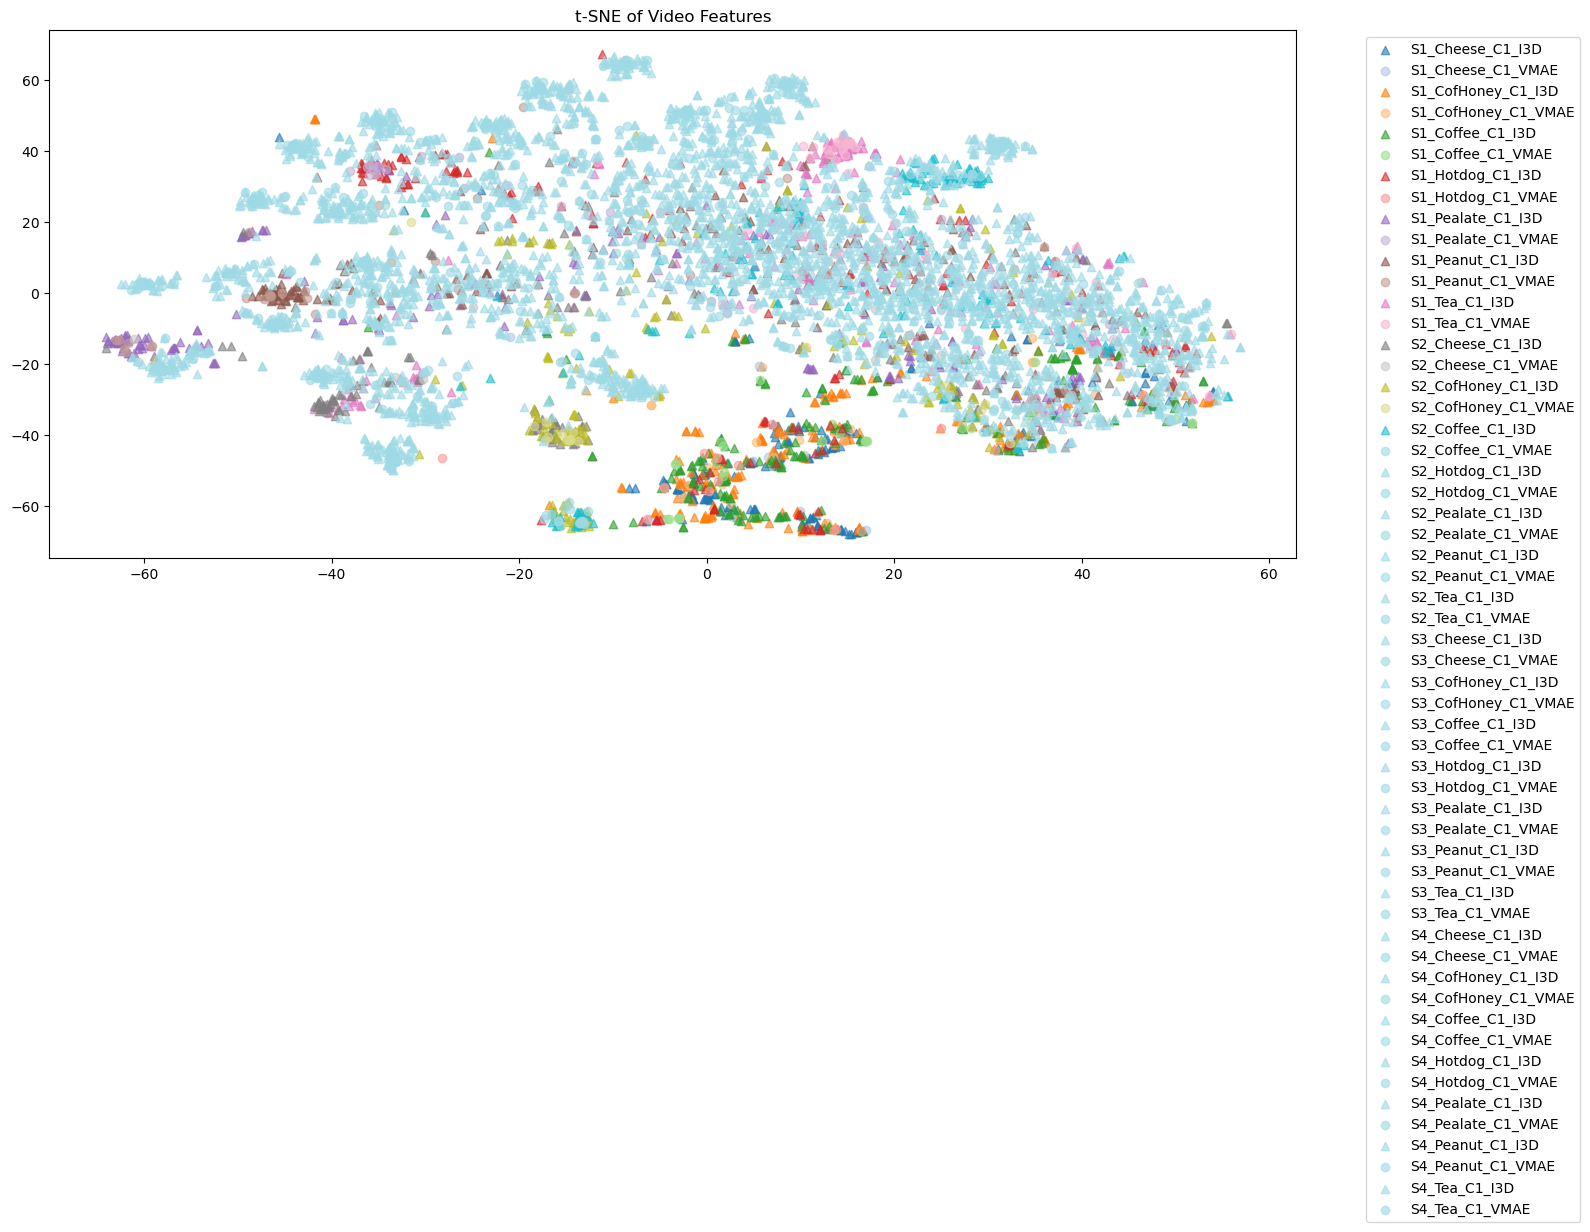

In [14]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.interpolate import interp1d

# Configuration
i3d_root = 'features/gteai3d'
vmae_root = 'features/gteamaev2'

# Get all video files
vmae_files = sorted([f for f in os.listdir(vmae_root) if f.endswith('.npy')])
i3d_files = sorted([f for f in os.listdir(i3d_root) if f.endswith('.npy')])

# Verify matching files
assert len(vmae_files) == len(i3d_files) == 28, "Number of files doesn't match"
assert all(v == i for v, i in zip(vmae_files, i3d_files)), "File names don't match"

# Load all features with metadata
video_data = []
for vmae_file, i3d_file in zip(vmae_files, i3d_files):
    vmae_feat = np.load(os.path.join(vmae_root, vmae_file))  # [T_vmae, D]
    i3d_feat = np.load(os.path.join(i3d_root, i3d_file))     # [T_i3d, D]

    video_data.append({
        'name': os.path.splitext(vmae_file)[0],
        'vmae': vmae_feat,
        'i3d': i3d_feat,
        'frames_vmae': vmae_feat.shape[0],
        'frames_i3d': i3d_feat.shape[0],
        'feature_dim': vmae_feat.shape[1]
    })

# Normalize
for data in video_data:
    data['vmae_norm'] = (data['vmae'] - data['vmae'].mean(axis=0)) / (data['vmae'].std(axis=0) + 1e-8)
    data['i3d_norm'] = (data['i3d'] - data['i3d'].mean(axis=0)) / (data['i3d'].std(axis=0) + 1e-8)

# Extract normalized features
vmae_features = [data['vmae_norm'] for data in video_data]
i3d_features = [data['i3d_norm'] for data in video_data]

# Fit shared PCA models
TARGET_DIM = 117
vmae_pca_model = PCA(n_components=TARGET_DIM).fit(np.concatenate(vmae_features))

max_i3d_dim = max(f.shape[1] for f in i3d_features)
padded_i3d_features = [
    np.pad(f, [(0, 0), (0, max_i3d_dim - f.shape[1])])
    for f in i3d_features
]
i3d_pca_model = PCA(n_components=TARGET_DIM).fit(np.concatenate(padded_i3d_features))

# Apply PCA to each video
vmae_features_reduced = [vmae_pca_model.transform(f) for f in vmae_features]
i3d_features_reduced = [
    i3d_pca_model.transform(np.pad(f, [(0, 0), (0, max_i3d_dim - f.shape[1])]))
    for f in i3d_features
]

# 1. Discriminability
def compute_discriminability(features_list, labels):
    all_features = np.concatenate(features_list)
    pca = PCA(n_components=min(50, all_features.shape[1]))
    reduced_features = pca.fit_transform(all_features)
    return silhouette_score(reduced_features, labels)

video_labels = np.concatenate([np.full(data['frames_vmae'], i) for i, data in enumerate(video_data)])
i3d_labels = np.concatenate([np.full(data['frames_i3d'], i) for i, data in enumerate(video_data)])

vmae_score = compute_discriminability(vmae_features_reduced, video_labels)
i3d_score = compute_discriminability(i3d_features_reduced, i3d_labels)

print("Video Discriminability Scores:")
print(f"VideoMAEv2: {vmae_score:.4f}\nI3D: {i3d_score:.4f}")

# 2. Temporal metrics
def compute_temporal_metrics(features):
    diffs = np.diff(features, axis=0)
    return np.mean(np.linalg.norm(diffs, axis=1)), np.mean(np.var(features, axis=0))

print("\nTemporal Analysis:")
print("Video\tVMAE Smooth\tVMAE Var\tI3D Smooth\tI3D Var")
for data in video_data:
    vs, vv = compute_temporal_metrics(data['vmae_norm'])
    is_, iv = compute_temporal_metrics(data['i3d_norm'])
    print(f"{data['name']}\t{vs:.4f}\t{vv:.4f}\t{is_:.4f}\t{iv:.4f}")

# 3. Cross-Approach comparison
def compare_approaches(vmae_feat, i3d_feat, vmae_frames, vmae_pca, i3d_pca, max_i3d_dim):
    vmae_reduced = vmae_pca.transform(vmae_feat)

    if i3d_feat.shape[1] < max_i3d_dim:
        i3d_feat = np.pad(i3d_feat, [(0, 0), (0, max_i3d_dim - i3d_feat.shape[1])])
    i3d_reduced = i3d_pca.transform(i3d_feat)

    interp_i3d = interp1d(
        np.arange(i3d_reduced.shape[0]) * 8,
        i3d_reduced,
        axis=0,
        bounds_error=False,
        fill_value="extrapolate"
    )(np.arange(vmae_frames))

    return np.mean(np.linalg.norm(vmae_reduced - interp_i3d, axis=1))

print("\nCross-Approach Comparison:")
print("Video\tAvg Distance")
for data in video_data:
    dist = compare_approaches(
        data['vmae_norm'], data['i3d_norm'], data['frames_vmae'],
        vmae_pca_model, i3d_pca_model, max_i3d_dim
    )
    print(f"{data['name']}\t{dist:.4f}")

# 4. Visualization
def plot_approaches(video_data, sample_fraction=0.1):
    np.random.seed(42)
    vmae_samples = []
    i3d_samples = []
    labels = []

    for data in video_data:
        # Sample VMAE
        v_idx = np.random.choice(data['frames_vmae'], int(data['frames_vmae'] * sample_fraction), replace=False)
        v_proj = vmae_pca_model.transform(data['vmae_norm'][v_idx])
        vmae_samples.append(v_proj)
        labels.extend([f"{data['name']}_VMAE"] * len(v_proj))

        # Sample I3D
        i_idx = np.random.choice(data['frames_i3d'], int(data['frames_i3d'] * sample_fraction), replace=False)
        i_feat = data['i3d_norm'][i_idx]
        if i_feat.shape[1] < max_i3d_dim:
            i_feat = np.pad(i_feat, [(0, 0), (0, max_i3d_dim - i_feat.shape[1])])
        i_proj = i3d_pca_model.transform(i_feat)
        i3d_samples.append(i_proj)
        labels.extend([f"{data['name']}_I3D"] * len(i_proj))

    all_features = np.concatenate(vmae_samples + i3d_samples)
    pca = PCA(n_components=min(50, all_features.shape[1])).fit_transform(all_features)
    embeddings = TSNE(n_components=2, perplexity=30).fit_transform(pca)

    plt.figure(figsize=(16, 10))
    for i, label in enumerate(np.unique(labels)):
        mask = np.array(labels) == label
        plt.scatter(
            embeddings[mask, 0], embeddings[mask, 1],
            label=label,
            c=[plt.cm.tab20(i)],
            marker='o' if '_VMAE' in label else '^',
            alpha=0.6
        )
    plt.title("t-SNE of Video Features")
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

print("\nGenerating visualization...")
plot_approaches(video_data)


In [7]:
def project_vmae_to_dim(features_list, target_dim=117):
    """Properly fits PCA before transformation"""
    # Stack all features for PCA fitting
    all_features = np.vstack(features_list)
    
    # Fit PCA on the complete dataset
    pca = PCA(n_components=target_dim)
    pca.fit(all_features)  # This was missing in original code!
    
    # Transform each video's features
    return [pca.transform(f) for f in features_list]

def project_i3d_to_common_dim(features_list, target_dim=117):
    """Handles variable I3D dimensions with proper PCA fitting"""
    # Find max dimension across all I3D features
    max_dim = max(f.shape[1] for f in features_list)
    
    # Pad all features to max_dim for PCA fitting
    padded_features = []
    for feat in features_list:
        pad_width = [(0, 0), (0, max_dim - feat.shape[1])]
        padded = np.pad(feat, pad_width, mode='constant')
        padded_features.append(padded)
    
    # Fit PCA on padded features
    all_features = np.vstack(padded_features)
    pca = PCA(n_components=target_dim)
    pca.fit(all_features)  # Critical step that was missing
    
    # Transform original features (with padding if needed)
    reduced_features = []
    for feat in features_list:
        if feat.shape[1] < pca.n_features_in_:
            pad_width = [(0, 0), (0, pca.n_features_in_ - feat.shape[1])]
            feat = np.pad(feat, pad_width, mode='constant')
        reduced_features.append(pca.transform(feat))
    
    return reduced_features

# Usage:
vmae_reduced = project_vmae_to_dim([data['vmae_norm'] for data in video_data])
i3d_reduced = project_i3d_to_common_dim([data['i3d_norm'] for data in video_data])